In [1]:
import matplotlib.pyplot as plt 
import torch
import torch.nn.functional as F
%matplotlib inline

c:\users\bigre\appdata\local\programs\python\python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
words = open('names.txt', 'r').read().splitlines()

In [3]:
# vocabulary of chars and mapping

chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos.keys()) 

print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
import random 
random.seed(42)
random.shuffle(words)

In [5]:
# build dataset 
window_size = 8 #context lenght

def build_dataset(words):
    X, Y = [], []
    for w in words:
        
        context = [0] * window_size
        for char in w + '.':
            ix = stoi[char]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
        
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    
    return X, Y

In [6]:
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X_train, Y_train = build_dataset(words[:n1]) # 80%
X_val, Y_val = build_dataset(words[n1:n2]) # 10%
X_test, Y_test = build_dataset(words[n2:]) # 10 %

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [7]:
for x, y in zip(X_train[:20], Y_train[:20]):
    print(''.join(itos[ix.item()] for ix in x ), '->', itos[y.item()])

........ -> y
.......y -> u
......yu -> h
.....yuh -> e
....yuhe -> n
...yuhen -> g
..yuheng -> .
........ -> d
.......d -> i
......di -> o
.....dio -> n
....dion -> d
...diond -> r
..diondr -> e
.diondre -> .
........ -> x
.......x -> a
......xa -> v
.....xav -> i
....xavi -> e


In [8]:
class Linear:
    
    def __init__(self, fan_in, fan_out, bias=True):
        self.weights = torch.randn((fan_in, fan_out)) / fan_in ** 0.5 # kaiming initialization of weights
        self.biases = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        
        self.out = x @ self.weights
        if self.biases is not None:
            self.out += self.biases
        return self.out
    
    def parameters(self):
        return [self.weights] + ([] if self.biases is None else [self.biases])
    
    

In [9]:
class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        
        # params for backprop
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        
        # buffers for approximation of mean and var of all datset
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        
        # calculate forward pass
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
            x_mean = x.mean(dim, keepdim=True) # batch mean
            x_var = x.var(dim, keepdim=True) # batch variance
        else:
            x_mean = self.running_mean
            x_var = self.running_var
        x_hat = (x - x_mean) / torch.sqrt(x_var + self.eps) # normalize to unit variance (eps for dodging zero division)
        self.out = self.gamma * x_hat + self.beta
        
        #update aprox buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * x_mean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * x_var
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
        

In [10]:
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

In [11]:
class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weights = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weights[IX]
        return self.out

    def parameters(self):
        return [self.weights]

# -----------------------------------------------------------------------------------------------
class FlattenConsecutive:
    def __init__(self, n):
        self.n = n
        
    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out

    def parameters(self):
        return []

# -----------------------------------------------------------------------------------------------
class Sequential:
    
    def __init__(self, layers):
        self.layers = layers
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        # get parameters of all layers and stretch them out into one list
        return [p for layer in self.layers for p in layer.parameters()]

In [12]:
torch.manual_seed(228)

In [13]:
n_emb = 24 # dimensionality of the characters embedding vector
n_hidden = 128 # the number of neurons in hidden layer of the MLP
model = Sequential([
    Embedding(vocab_size, n_emb),
    FlattenConsecutive(2), Linear(n_emb * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])

# parameters initialization 
with torch.no_grad():
    model.layers[-1].weights *= 0.1
    
parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # total number of parameters
for p in parameters:
    p.requires_grad = True
    

76579


In [14]:
ix = torch.randint(0, X_train.shape[0], (4,))
Xb, Yb = X_train[ix], Y_train[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0, 13,  1, 18],
        [ 0,  0,  0,  0,  0,  0,  0,  1],
        [ 0,  0,  0,  0,  0,  0,  0,  1],
        [ 0,  0,  0, 12,  1,  1, 19, 25]])

In [15]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 24)
FlattenConsecutive : (4, 4, 48)
Linear : (4, 4, 128)
BatchNorm1d : (4, 4, 128)
Tanh : (4, 4, 128)
FlattenConsecutive : (4, 2, 256)
Linear : (4, 2, 128)
BatchNorm1d : (4, 2, 128)
Tanh : (4, 2, 128)
FlattenConsecutive : (4, 256)
Linear : (4, 128)
BatchNorm1d : (4, 128)
Tanh : (4, 128)
Linear : (4, 27)


In [16]:
max_steps = 200000
batch_size = 32
loss_i = []

for i in range(max_steps):
    
    #mini-batching
    ix = torch.randint(0, X_train.shape[0], (batch_size,))
    X_b, Y_b = X_train[ix], Y_train[ix]
    
    #forward pass
    logits = model(X_b)
    loss = F.cross_entropy(logits, Y_b)
    
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # elementary SGD
    lr = 0.1 if i < 150000 else 0.01 # learning rate decay
    for p in parameters:
        p.data -= lr * p.grad
        
    # stats tracking
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    loss_i.append(loss.log10().item())
    

      0/ 200000: 3.3105
  10000/ 200000: 2.0215
  20000/ 200000: 2.0349
  30000/ 200000: 2.4120
  40000/ 200000: 2.1498
  50000/ 200000: 1.5067
  60000/ 200000: 1.9049
  70000/ 200000: 1.6649
  80000/ 200000: 1.7524
  90000/ 200000: 1.6771
 100000/ 200000: 1.5249
 110000/ 200000: 1.9449
 120000/ 200000: 1.5392
 130000/ 200000: 1.6513
 140000/ 200000: 2.0610
 150000/ 200000: 1.5131
 160000/ 200000: 2.0238
 170000/ 200000: 1.6249
 180000/ 200000: 1.4447
 190000/ 200000: 1.6227


In [17]:
torch.tensor(loss_i).view(-1, 1000).shape, torch.tensor(loss_i).view(-1, 1000).mean(1).shape

(torch.Size([200, 1000]), torch.Size([200]))

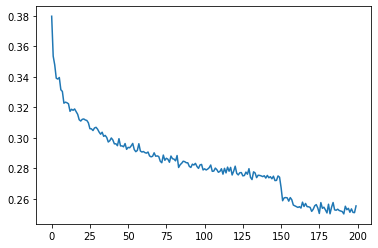

In [18]:
plt.plot(torch.tensor(loss_i).view(-1, 1000).mean(1))

In [19]:
for layer in model.layers:
    layer.training = False

In [20]:
#evaluate the loss
@torch.no_grad() # 
def split_loss(split):
    x, y = {
        'train': (X_train, Y_train),
        'val': (X_val, Y_val),
        'test':(X_test, Y_test)
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
    
split_loss('train')
split_loss('val')
    

train 1.7686811685562134
val 1.9882631301879883


In [21]:
# sample from the model
for _ in range(20):

    out = []
    context = [0] * window_size # initialize with all ...
    while True:
        # forward pass the neural net
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

gabrielyn.
willy.
shymder.
kartnea.
masjin.
jourram.
indi.
elouri.
zibylar.
alifayah.
reonna.
zland.
johna.
etxon.
khayman.
elannie.
everlynn.
bryal.
rachith.
suhayla.
